In [ ]:
# The path where you would like to save your models
model_path = '../model'

# the path where the datasets are
project_path = '../Pics'
train_path = join(project_path, 'train')
vali_path = join(project_path, 'validate')

# The path of the pre-trained model that you would like to load 
old_model_path = join('../model/model.h5')

# The path where you would like to save your plots of training 
plot_path = '../plot'

In [3]:
import tensorflow as tf
from os.path import join
from glob import glob
import numpy as np
import os


def load_dataset(project_path, BATCH_SIZE=256, BUFFER_SIZE=500, IMAGE_SIZE=(256, 256)):
    image_path = os.path.join(project_path, 'images/')
    mask_path = os.path.join(project_path, 'masks/')
    image_list = os.listdir(image_path)
    mask_list = os.listdir(mask_path)
    image_list = [image_path + i for i in image_list]
    mask_list = [mask_path + i for i in mask_list]

    image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
    mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)
    image_filenames = tf.constant(image_list)
    masks_filenames = tf.constant(mask_list)
    dataset = tf.data.Dataset.from_tensor_slices(
        (image_filenames, masks_filenames))

    def process_path(image_path, mask_path):
        img = tf.io.read_file(image_path)
        img = tf.image.decode_png(img, channels=3)
        img = tf.image.convert_image_dtype(img, tf.float32)

        mask = tf.io.read_file(mask_path)
        mask = tf.image.decode_png(mask, channels=1)
        mask = tf.image.convert_image_dtype(mask, tf.float32)
        return img, mask

    def preprocess(image, mask):
        input_image = tf.image.resize(image, IMAGE_SIZE, method='nearest')
        input_mask = tf.image.resize(mask, IMAGE_SIZE, method='nearest')

        return input_image, input_mask

    image_ds = dataset.map(process_path)
    processed_image_ds = image_ds.map(preprocess)
    processed_image_ds.batch(BATCH_SIZE)

    dataset = processed_image_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    return dataset


In [4]:
import tensorflow.keras.layers as tfl


def conv_block(inputs=None, n_filters=64, dropout_prob=0.0, max_pooling=True):
    conv = tfl.Conv2D(n_filters,  # Number of filters
                      3,  # Kernel size
                      padding='same',
                      kernel_initializer='he_normal')(inputs)
    conv = tfl.BatchNormalization()(conv)
    conv = tfl.Activation('leaky_relu')(conv)
    conv = tfl.Conv2D(n_filters,  # Number of filters
                      3,  # Kernel size
                      padding='same',
                      kernel_initializer='he_normal')(conv)
    conv = tfl.BatchNormalization()(conv)
    conv = tfl.Activation('leaky_relu')(conv)

    if dropout_prob > 0:
        conv = tfl.Dropout(dropout_prob)(conv)

    if max_pooling:
        next_layer = tf.keras.layers.MaxPool2D(
            pool_size=(2, 2), strides=2)(conv)
    else:
        next_layer = conv
    skip_connection = conv
    return next_layer, skip_connection


def upsampling_block(expansive_input, contractive_input, n_filters=64):
    up = tfl.Conv2DTranspose(
        n_filters,  # number of filters
        3,  # Kernel size
        strides=2,
        padding='same')(expansive_input)

    merge = tfl.concatenate([up, contractive_input], axis=3)
    conv = tfl.Conv2D(n_filters,  # Number of filters
                      3,  # Kernel size
                      padding='same',
                      kernel_initializer='he_normal')(merge)
    conv = tfl.BatchNormalization()(conv)
    conv = tfl.Activation('leaky_relu')(conv)
    conv = tfl.Conv2D(n_filters,  # Number of filters
                      3,  # Kernel size
                      padding='same',
                      kernel_initializer='he_normal')(conv)
    conv = tfl.BatchNormalization()(conv)
    conv = tfl.Activation('leaky_relu')(conv)
    return conv


def creat_model(image_size, dropout_prob):
    n_filters = 64
    input_size = image_size + (3,)
    inputs = tfl.Input(input_size)
    cblock1 = conv_block(inputs, n_filters)
    cblock2 = conv_block(cblock1[0], n_filters * 2)
    cblock3 = conv_block(cblock2[0], n_filters * 4)
    cblock4 = conv_block(cblock3[0], n_filters * 8, dropout_prob=dropout_prob)
    cblock5 = conv_block(cblock4[0], n_filters * 16,
                         dropout_prob=dropout_prob, max_pooling=False)
    ublock6 = upsampling_block(cblock5[0], cblock4[1], n_filters * 8)
    ublock7 = upsampling_block(ublock6, cblock3[1], n_filters * 4)
    ublock8 = upsampling_block(ublock7, cblock2[1], n_filters * 2)
    ublock9 = upsampling_block(ublock8, cblock1[1], n_filters)

    conv9 = tfl.Conv2D(n_filters,
                       3,
                       activation='relu',
                       padding='same',
                       kernel_initializer='he_normal')(ublock9)
    if dropout_prob > 0.0:
        conv9 = tfl.Dropout(dropout_prob)(conv9)
    conv10 = tfl.Conv2D(1, 1, activation='sigmoid', padding='same')(conv9)
    model = tf.keras.Model(inputs=inputs, outputs=conv10)
    return model


In [5]:
import json
import matplotlib.pyplot as plt


def history_plot(history, project_path, metric):
    history_dict = history.history
    out_path = join(project_path, 'history')
    if not os.path.exists(out_path):
        os.makedirs(out_path)
    dict_path = join(out_path, 'history')
    json.dump(history_dict, open(dict_path, 'w'))
    fig1, ax1 = plt.subplots(dpi=300)
    fig2, ax2 = plt.subplots(dpi=300)
    ax1.plot(history_dict['loss'], label='Train Loss')
    ax1.plot(history_dict['val_loss'], label='Val Loss')
    ax2.plot(history_dict[metric], label='Train ' + metric)
    ax2.plot(history_dict['val_' + metric], label='Val ' + metric)
    ax1.legend()
    ax2.legend()
    loss_path = join(out_path, 'loss.png')
    accuracy_path = join(out_path, metric + '.png')
    fig1.savefig(loss_path)
    fig2.savefig(accuracy_path)
    plt.show()


In [6]:


class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        epoch += 1
        if epoch % 5 == 0:
            model_dir = os.path.join(model_path, str(epoch) + '.h5')
            if not os.path.exists(model_path):
                os.makedirs(model_path)
            print("Saving Model on Epoch {} ...".format(epoch))
            model.save_weights(model_dir)


In [7]:
def iou_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    inter = tf.math.multiply(y_true, y_pred)
    union = tf.math.subtract(tf.math.add(y_true, y_pred), inter)
    iou = tf.math.divide(tf.reduce_sum(inter), tf.reduce_sum(union))
    Liou = tf.math.subtract(tf.constant(1.0), iou)
    return Liou


In [8]:
def Binary_IoU(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    inter = tf.math.multiply(y_true, y_pred)
    union = tf.math.subtract(tf.math.add(y_true, y_pred), inter)
    iou = tf.math.divide(tf.reduce_sum(inter), tf.reduce_sum(union))
    return iou


In [9]:
def Dice_Loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
#     y_pred = tf.math.greater(y_pred, 0.5)
    y_pred = tf.cast(y_pred, tf.float32)
    inter = tf.math.multiply(y_true, y_pred)
    union = tf.math.divide(tf.math.add(
        tf.reduce_sum(y_true), tf.reduce_sum(y_pred)), 2)
    score = tf.math.divide(tf.reduce_sum(inter), tf.reduce_sum(union))
    loss = tf.math.subtract(tf.constant(1.0), score)
    return loss


In [10]:
def Dice_Score(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.math.greater(y_pred, 0.5)
    y_pred = tf.cast(y_pred, tf.float32)
    inter = tf.math.multiply(y_true, y_pred)
    union = tf.math.divide(tf.math.add(
        tf.reduce_sum(y_true), tf.reduce_sum(y_pred)), 2)
    score = tf.math.divide(tf.reduce_sum(inter), tf.reduce_sum(union))
    return score


In [11]:
import os
image_size = (256, 256)
batch_size = 16
seed = 77

train_dataset = load_dataset(
    train_path, IMAGE_SIZE=image_size, BATCH_SIZE=batch_size)
vali_dataset = load_dataset(
    vali_path, IMAGE_SIZE=image_size, BATCH_SIZE=batch_size)


# If you would like to creat a new model
# model = creat_model(image_size, dropout_prob=0.1)

# If you would like to load an pre-trained model and its weights
model = tf.keras.models.load_model(old_model_path, custom_objects={"Dice_Loss": Dice_Loss, "Dice_Score": Dice_Score})

# If you would like to create a new model but use pre-trained weights
# old_model = tf.keras.models.load_model(old_model_path, custom_objects={
#                                        "iou_loss": iou_loss, "Binary_IoU": Binary_IoU})
# model.load_weights(old_model.get_weights())

# If you would like to load saved weights
# model.load_weights('model/weights.h5')

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-04-14 20:05:46.946797: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-14 20:05:46.946961: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [ ]:
# Simple data augmentation
class Augment(tf.keras.layers.Layer):
    def __init__(self, seed=77):
        super().__init__()
        # both use the same seed, so they'll make the same random changes.
        self.augment_inputs = tf.keras.layers.RandomFlip(
            mode="horizontal_and_vertical", seed=seed)
        self.augment_labels = tf.keras.layers.RandomFlip(
            mode="horizontal_and_vertical", seed=seed)
        self.augment_inputs = tf.keras.layers.RandomRotation(
            factor=0.5, seed=seed)
        self.augment_labels = tf.keras.layers.RandomRotation(
            factor=0.5, seed=seed)

    def call(self, inputs, labels):
        inputs = self.augment_inputs(inputs)
        labels = self.augment_labels(labels)
        return inputs, labels


AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.map(Augment(), num_parallel_calls=AUTOTUNE)

# Choose the optimizer (recommanded SGD with high momentum if batch size is small)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
# optimizer = 'adam'

# You may choose your own loss and metrics
model.compile(optimizer=optimizer,
              loss=Dice_Loss,
              metrics=[Dice_Score])

model.summary()

# Specify epochs
epochs = 50
model_history = model.fit(train_dataset,
                          validation_data=vali_dataset, epochs=epochs, callbacks=[MyCallback()])

# Plot
history_plot(model_history, plot_path)
model_dir = os.path.join(model_path, 'final.h5')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
model.save(os.path.join(model_path, 'model.h5'))

In [50]:
def display(display_list, figsize=15, index=0, fontsize=20):
    plt.figure(figsize=(figsize, figsize))

    title = ['Input Image', 'Predicted Mask', 'True Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i], fontdict={'fontsize': fontsize})
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.savefig('result/{}.png'.format(index), dpi=300)
    plt.show()

In [ ]:
import cv2
img_path = 'Pics/train/images'
mask_path = 'Pics/train/masks'
img_list = os.listdir(img_path)
img_list.sort()
mask_list = os.listdir(mask_path)
mask_list.sort()
for img_n, mask_n in zip(img_list, mask_list):
    img_p = join(img_path, img_n)
    mask_p = join(mask_path, mask_n)
    img = np.resize(cv2.imread(img_p), (1, 256, 256, 3))
    mask = np.resize(cv2.imread(mask_p), (1, 256, 256, 3))
    pred = model(img / 255.0)
    pred = np.repeat(pred, 3, axis=-1)
    # print(mask.shape)
    display([img[0] / 255.0, pred[0], mask[0] / 255.0])
    # print(np.max(pred[0]))
    # break

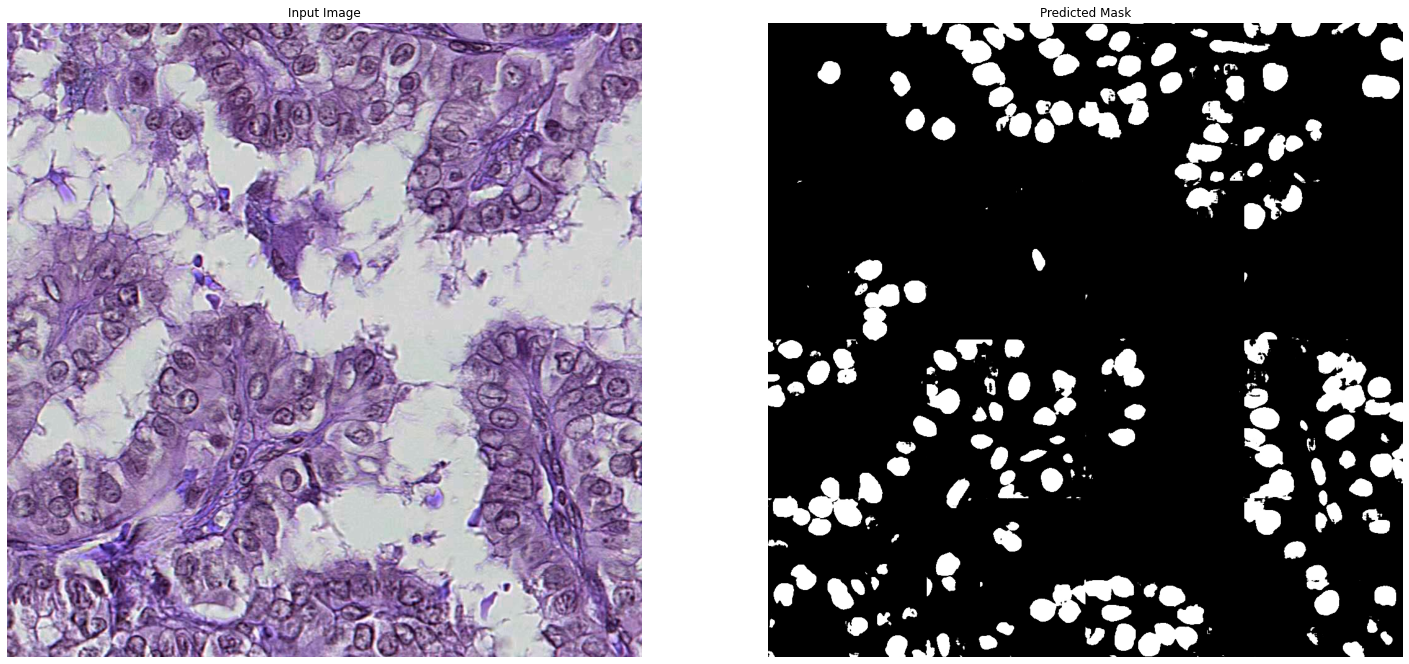

In [36]:
# Whole 1024*1024 Image

import cv2
img_path = 'test/M2020-2516-5436.png'
ori = cv2.imread(img_path)
final = np.array([]).reshape((0, 1024, 3))
for i in range(4):
    row = np.array([]).reshape((256, 0, 3))
    for j in range(4):
        h = i * 256
        w = j * 256
        img = ori[h:h + 256, w: w + 256]
        img = np.reshape(img, (1, 256, 256, 3))
        pred = model(img / 255.0)
        pred = np.repeat(pred, 3, axis=-1)
        # print(mask.shape)
        # display([img[0] / 255.0, pred[0]])
        row = np.concatenate((row, pred[0]), axis=1)
        # print(np.max(pred[0]))
    final = np.concatenate((final, row), axis=0)
display([ori, final])

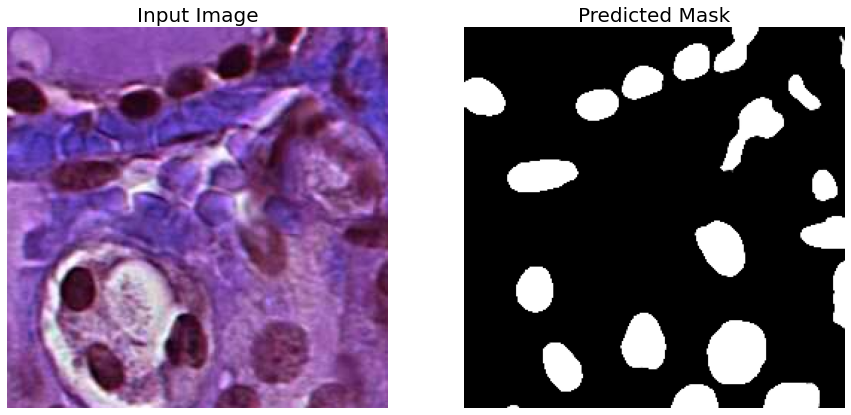

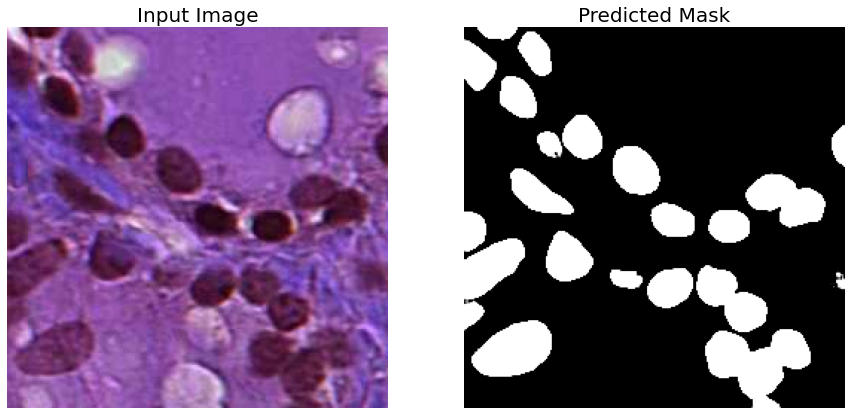

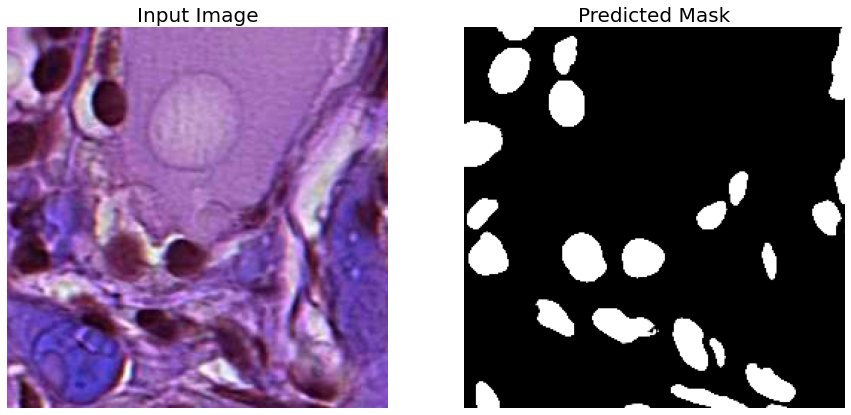

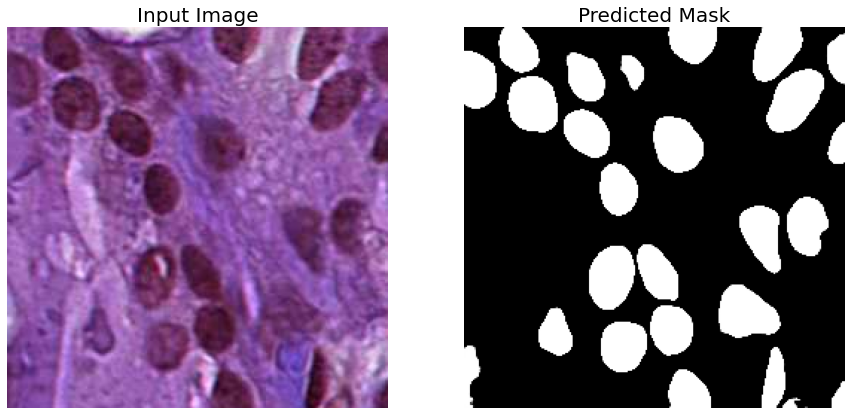

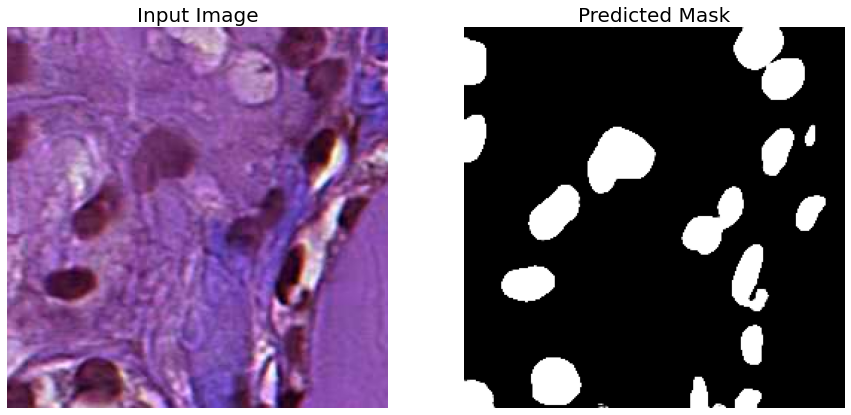

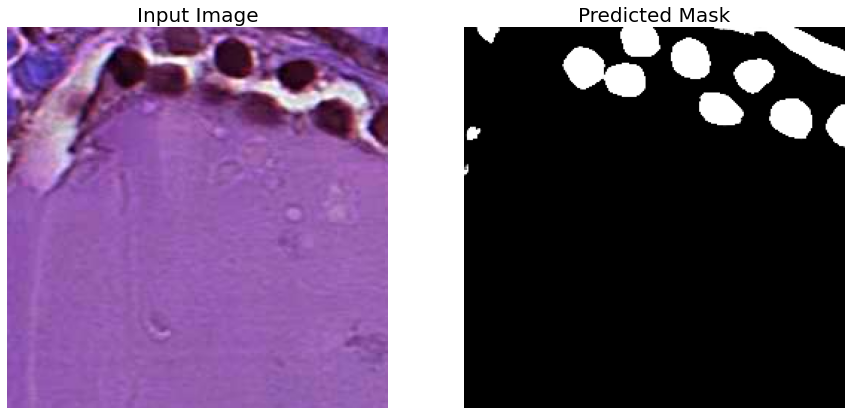

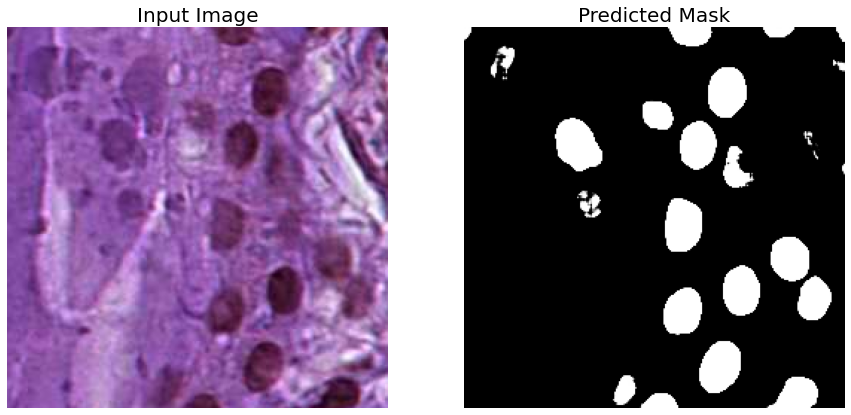

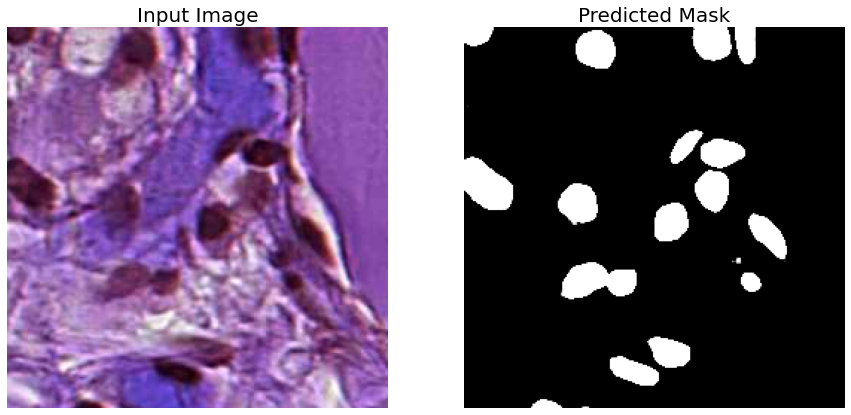

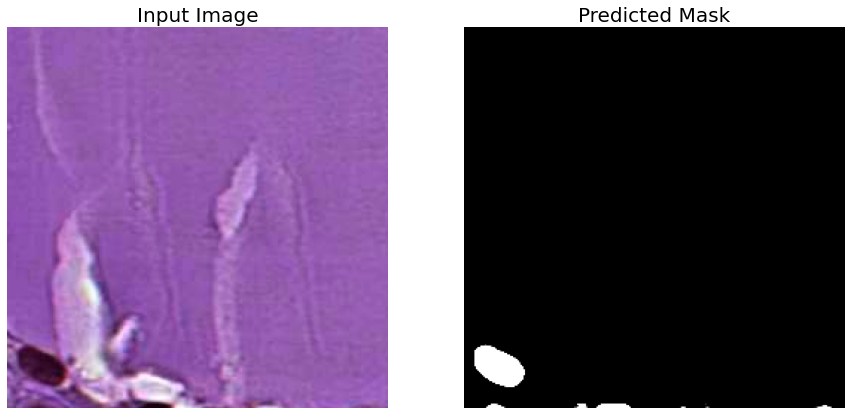

In [51]:
import cv2
img_path = 'test/M2020-2570-11609.png'
ori = cv2.imread(img_path)
for i in range(3):
    for j in range(3):
        h = i * 256
        w = j * 256
        img = ori[h:h + 256, w: w + 256]
        img = np.reshape(img, (1, 256, 256, 3))
        pred = model(img / 255.0)
        pred = np.repeat(pred, 3, axis=-1)
        display([img[0] / 255.0, pred[0]], index=i * 3+j)